# Shroedinger bridges via Maximum Likelihood estimation

In [92]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
from sklearn.datasets import make_blobs, make_swiss_roll

from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

## 1. Dynamic Shroedinger bridge problem

### 1.1 DSBP

We start with Dynamic Shroedinger Bridge Problem (DSBP) between two data distribution $\pi_{0}$ and $\pi_{1}$ correspondingly. One would like to find process $\mathbb{Q}$ that is descrided by the SDE 
$$dx(t) = b(x,t)dt + \sqrt{\gamma}dW(t)$$, which is more closed to the prior process $\mathbb{Q}_{0}^{\gamma}$.

The Wiener process is the prior process $\mathbb{Q}_{0}^{\gamma}$ with $\gamma$ volatility. In other words, $\mathbb{Q}_{0}^{\gamma}$ is the stochastic process that is described by the following stochastic differential equation with initial distribution $\pi_{0}^{\mathbb{Q}_{0}^{\gamma}}$ for the prior process.

$$dx(t) = \sqrt{\gamma}dW(t), \quad x(0) \sim \pi_{0}^{\mathbb{Q}_{0}^{\gamma}}$$

Thus, the DSBP is defined as in KL terms:

$$ \min_{\mathbb{Q} \in \mathcal{D}(\pi_{0},\pi_{1})} \mathbb{D}_{KL}(\mathbb{Q}||\mathbb{Q}_{0}^{\gamma})$$

### 1.2 Stochastic control formulation

The lemma 2 (Pavon and Wakolbinger) from the paper states the following equivalence between DSBP and Stochastic control formulation.

$$ \min_{\mathbb{Q} \in \mathcal{D}(\pi_{0},\pi_{1})} \mathbb{D}_{KL}(\mathbb{Q}||\mathbb{Q}_{0}^{\gamma}) \iff 
    \min_{b \in \mathcal{B}} \int_{0}^{1} \int_{\mathbb{R}^{n}}\frac{1}{2\gamma} \rho(t, x)||b(x,t)||^{2} dx dt $$
    
with the following border conditions
 
$$ dx(t) = b(x,t)dt + \sqrt{\gamma}dW(t) , \quad x(0) \sim \pi_{0} , \quad x(1) \sim \pi_{1}$$

With Euler-Maruyama discretization:

$$x(t) = x(t-1) + b(x(t-1),t-1)dt + \epsilon \sqrt{\gamma} \sqrt{dt} $$

### 1.3 Implementation of Stochastic Control formulation 

For the implementation of stochastic control formulation we parametrize drift coefficient as a deep neural network
- $b_{\theta}(x,t): \mathbb{R}^{n+1} \to \mathbb{R}^{n}$
- $\gamma$ (variance of SDE) is fixed.
- One has to satisfy boarder conditions : $x(0) \sim \pi_{0}, \quad x(1) \sim \pi_{1}$

#### 1.3.1 Deep Neural Network for Drift coefficient

In [100]:
def drift_net(hiddens):
    
    model = []
    for inp, out in zip(hiddens[:-1],hiddens[1:]):
        model.append(torch.nn.Linear(inp, out, bias = True))
        model.append(torch.nn.ReLU())
    model.pop()
    
    return torch.nn.Sequential(*model)

#### 1.3.2 Data for Experiments

In [ ]:
def make_gaussians_dataset(n_samples, n_gaussians=8, radius=1, std=1):
    
    """Makes n gaussians with centers on a circle of given radius"""
    
    angle_between_gaussians = 2*np.pi/n_gaussians
    centers = radius*np.array([
        [np.cos(i*angle_between_gaussians), np.sin(i*angle_between_gaussians)] for i in range(n_gaussians)
        ]
    )

    data = make_blobs(n_samples, n_features=2, centers=centers, cluster_std=std)[0]

    return TensorDataset(torch.tensor(data).float())

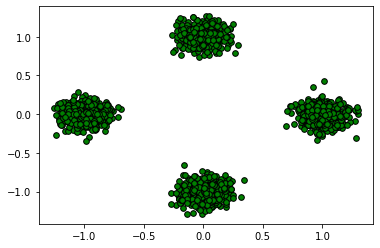

In [572]:
input_dataset = make_gaussians_dataset(n_samples = 2000, n_gaussians=4, radius=1, std=0.1)
plt.scatter(input_dataset.tensors[0].numpy()[:, 0], input_dataset.tensors[0].numpy()[:, 1],
        c="g", s=32, edgecolors="black");

In [116]:
def make_swiss_roll_dataset(n_samples, scale=0.2, std=1):
    data = scale*make_swiss_roll(n_samples=n_samples, noise=std)[0][:, [0, 2]]
    
    return TensorDataset(torch.tensor(data).float())

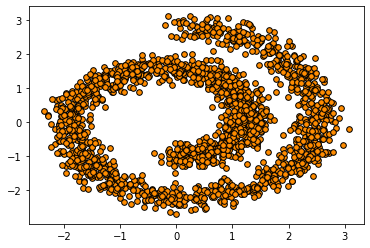

In [118]:
output_dataset =  make_swiss_roll_dataset(n_samples = 2000, scale=0.2, std=1)
plt.scatter(output_dataset.tensors[0].numpy()[:, 0], output_dataset.tensors[0].numpy()[:, 1],
        c="darkorange", s=32, edgecolors="black");

In [119]:
class DataLoaderSampler():
    
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.iterator = iter(data_loader)
        
    def sample(self):
        sample = next(self.iterator, None)
        if sample is None:
            self.iterator = iter(self.data_loader)
            sample = next(self.iterator, None)
            
        return sample[0]

#### 1.3.3 Stochastic Differential equation

In [84]:
class SDE(torch.nn.Module):
    
    def __init__(self, drift, var, n_steps):
         
        """
        drift   - torch.nn.Module : DIM + 1 -> DIM
        var     - float
        n_steps - int
        
        """
        super().__init__()
        
        self.drift = drift # requires gradient
        self.var = var
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
        
        
    def forward(self, x0):
        
        """
        x0 - torch.Size([B,N])
        
        """
        trajectory = [x0]
        times = [0]
        drifts = []
        
        x, t = x0, times[0]
        
        for step in range(self.n_steps):
            x, t, drift = self._step(x, t)
            
            trajectory.append(x)
            times.append(t)
            drifts.append(drift)
            
        return torch.stack(trajectory, dim = 1), torch.tensor(times), torch.stack(drifts, dim = 1)
    
    def noise_sample(self, x):
        
        """
        x - torch.Size([B,N])
        
        """
        return torch.randn(x.shape)
    
    def get_drift(self, x, t):
        
        batch_size = x.shape[0]
        t = torch.tensor(t).repeat(batch_size)
        
        inp = torch.cat((x, t[:, None]), dim = -1)
        return self.drift(inp)
        
    
    def _step(self, x, t):
        
        epsilon = self.noise_sample(x)
        drift =  self.get_drift(x, t)
        
        return x + self.delta_t*drift + epsilon*math.sqrt(self.delta_t)*torch.sqrt(self.var), t + self.delta_t, drift

The following function is used for calculation

$$\min_{b \in \mathcal{B}} \int_{0}^{1} \int_{\mathbb{R}^{n}}\frac{1}{2\gamma} \rho(t, x)||b(x,t)||^{2} dx dt = \min_{b \in \mathcal{B}} \mathbb{E}_{\mathbb{Q}}\int_{0}^{1} \frac{1}{2\gamma}  ||b(x,t)||^{2} dt, \quad x \sim \rho(t,x) $$

In [85]:
def integrate(values, times):
    deltas = times[1:] - times[:-1]
    return (values*deltas[None, :]).sum(dim = 1)

#### 1.3.4. Training SDE function

In [138]:
def train(input_distr_sampler, output_distr_sampler,
          sde, sde_opt,
          sde_noise_std, iterations, 
          inner_iterations):
    
    norms = []
    integral_scale = 1
    max_norm = 1
    
    for iteration in tqdm(range(iterations)):
        x0, x1 = input_distr_sampler.sample(), output_distr_sampler.sample()
        x0, x1 = x0.to(device), x1.to(device)
        
        trajectory, times, drifts = sde(x0)
        xN = trajectory[:, -1, :]
        
        norm = torch.norm(drifts, p=2, dim=-1)**2
        
        
        if iteration % 10 == 0:
            clear_output()
            
            transfered_dataset = map_dataset(sde, original_dataset)
            plot_results(input_dataset, output_dataset, transfered_dataset)
            plt.show()
            
        """
        integral = integral_scale*integrate(norm, times)
        
        loss_beta = (-integral - beta_net(x1) + beta_net(xN)).mean()
        beta_net_opt.zero_grad()
        loss_beta.backward()
        beta_net_opt.step()
        """
        
        for inner_iteration in range(inner_iterations):
            x0, x1 = input_distr_sampler.sample(), output_distr_sampler.sample()
            x0, x1 = x0.to(device), x1.to(device)

            trajectory, times, shifts = sde(x0)
            xN = trajectory[:, -1, :]

            norm = torch.norm(shifts, p=2, dim=-1)**2
            integral = integral_scale*integrate(norm, times)
            
            loss_sde = (integral).mean()
            sde_opt.zero_grad()
            loss_sde.backward()
            sde_opt.step()
        
            
    return sde, norms

#### 1.3.5 Utils

In [139]:
@torch.no_grad()
def map_dataset(sde, original_dataset, batch_size=32):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    transfered_data = []

    for x0 in DataLoader(original_dataset, batch_size=batch_size):
        x0 = x0[0].to(device)
        
        trajectory, times, _ = sde(x0)
        xN = trajectory[:, -1, :]

        transfered_data.append(xN.cpu())

    transfered_data = torch.cat(transfered_data)
    
    return TensorDataset(transfered_data)

In [135]:
def plot_results(original_dataset, target_dataset, transfered_dataset):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].scatter(
        original_dataset.tensors[0].numpy()[:, 0], original_dataset.tensors[0].numpy()[:, 1],
        c="g", s=32, edgecolors="black"
    )
    axes[0].set_title("Input distribution")

    axes[1].scatter(
        target_dataset.tensors[0].numpy()[:, 0], target_dataset.tensors[0].numpy()[:, 1],
        c="orange", s=32, edgecolors="black"
    )
    axes[1].set_title("Target distribution")

    axes[2].scatter(
        transfered_dataset.tensors[0].numpy()[:, 0], transfered_dataset.tensors[0].numpy()[:, 1],
        c="yellow", s=32, edgecolors="black"
    )
    axes[2].set_title("Fitted distribution")
    
    for i in range(3):
        axes[i].grid()
        axes[i].set_xlim([-2.5, 2.5])
        axes[i].set_ylim([-2.5, 2.5])
    
    plt.plot()

#### 1.3.6 Training

torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])


torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])


torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])


torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])


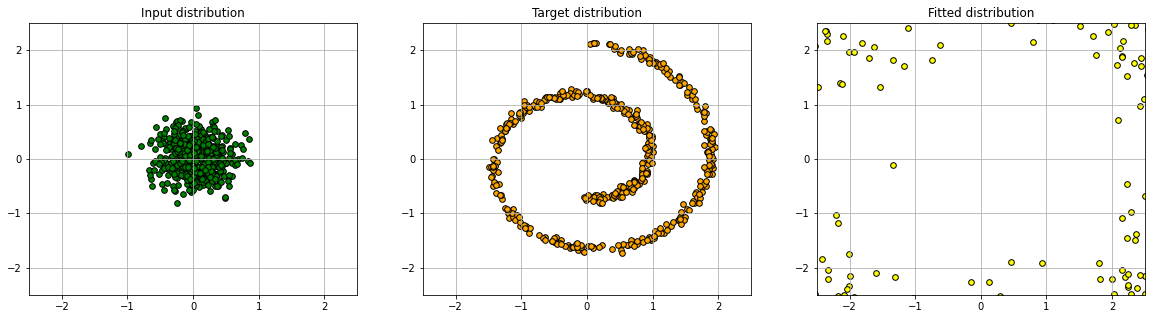

 99%|█████████▉| 991/1000 [03:31<00:03,  2.37it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 993/1000 [03:31<00:01,  3.62it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


100%|█████████▉| 995/1000 [03:31<00:00,  5.22it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


100%|█████████▉| 996/1000 [03:31<00:00,  6.00it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 998/1000 [03:31<00:00,  6.70it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|██████████| 1000/1000 [03:32<00:00,  4.72it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


In [141]:
DIM = 2
HIDDENS = [DIM + 1, 64, 128, 64 ,DIM]
SDE_VAR = 0.1
N_STEPS = 10
DATASET_SAMPLES = 500
N_COMPONENTS = 1
RADIUS = 0
STD = 0.3
SCALE = 0.15
BATCH_SIZE = 64
ITERATIONS = 1000
INNER_ITERATIONS = 10
LR = 1e-3
DEVICE = "CPU"

sde_drift_model = drift_net(HIDDENS)
sde = SDE(drift=sde_drift_model, var=SDE_VAR, n_steps=N_STEPS)
sde_opt = torch.optim.Adam(sde.parameters(), lr=LR)

input_dataset = make_gaussians_dataset(DATASET_SAMPLES, n_gaussians=N_COMPONENTS,
                                          radius=RADIUS, std=STD)
output_dataset = make_swiss_roll_dataset(DATASET_SAMPLES, scale=SCALE, std=STD)
input_distr_sampler = DataLoaderSampler(DataLoader(input_dataset, BATCH_SIZE))
output_distr_sampler = DataLoaderSampler(DataLoader(output_dataset, BATCH_SIZE))

sde, norms = train(input_distr_sampler, output_distr_sampler,
                      sde, sde_opt, SDE_VAR,ITERATIONS,INNER_ITERATIONS)

torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])
torch.Size([32, 2]) torch.Size([32, 2])


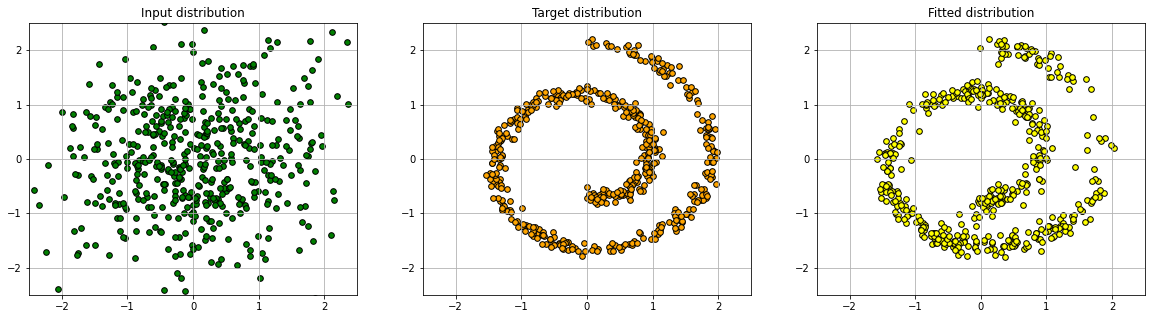

 99%|█████████▉| 9901/10000 [1:14:57<00:23,  4.29it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


 99%|█████████▉| 9903/10000 [1:14:58<00:17,  5.60it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9904/10000 [1:14:58<00:15,  6.13it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9906/10000 [1:14:58<00:13,  6.86it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9907/10000 [1:14:58<00:13,  7.15it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9909/10000 [1:14:58<00:12,  7.51it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9911/10000 [1:14:59<00:11,  7.73it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9912/10000 [1:14:59<00:11,  7.73it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9914/10000 [1:14:59<00:11,  7.80it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9916/10000 [1:14:59<00:10,  7.91it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9917/10000 [1:14:59<00:10,  7.87it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9919/10000 [1:15:00<00:10,  7.78it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


 99%|█████████▉| 9920/10000 [1:15:00<00:10,  7.93it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9922/10000 [1:15:00<00:09,  7.97it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9923/10000 [1:15:00<00:09,  7.97it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9925/10000 [1:15:00<00:09,  8.04it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9927/10000 [1:15:01<00:09,  7.99it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9928/10000 [1:15:01<00:09,  7.88it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9930/10000 [1:15:01<00:09,  7.77it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9932/10000 [1:15:01<00:08,  8.02it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9933/10000 [1:15:01<00:08,  8.03it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9935/10000 [1:15:02<00:08,  7.96it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9936/10000 [1:15:02<00:08,  7.90it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9938/10000 [1:15:02<00:07,  7.96it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9940/10000 [1:15:02<00:07,  7.97it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9941/10000 [1:15:02<00:07,  7.82it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


 99%|█████████▉| 9943/10000 [1:15:03<00:07,  8.07it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9944/10000 [1:15:03<00:06,  8.05it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9946/10000 [1:15:03<00:06,  7.95it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9948/10000 [1:15:03<00:06,  7.88it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


 99%|█████████▉| 9949/10000 [1:15:03<00:06,  7.87it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


100%|█████████▉| 9951/10000 [1:15:04<00:06,  7.93it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9952/10000 [1:15:04<00:06,  7.88it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9954/10000 [1:15:04<00:05,  7.71it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9956/10000 [1:15:04<00:05,  7.91it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9957/10000 [1:15:04<00:05,  7.93it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


100%|█████████▉| 9959/10000 [1:15:05<00:05,  7.96it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9960/10000 [1:15:05<00:05,  7.83it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9962/10000 [1:15:05<00:04,  7.84it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9964/10000 [1:15:05<00:04,  7.92it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9965/10000 [1:15:05<00:04,  7.91it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


100%|█████████▉| 9967/10000 [1:15:06<00:04,  7.92it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9968/10000 [1:15:06<00:04,  7.93it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9970/10000 [1:15:06<00:03,  7.90it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9972/10000 [1:15:06<00:03,  7.88it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9973/10000 [1:15:06<00:03,  7.88it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])


100%|█████████▉| 9975/10000 [1:15:07<00:03,  7.89it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9976/10000 [1:15:07<00:03,  7.93it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9978/10000 [1:15:07<00:02,  7.97it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9980/10000 [1:15:07<00:02,  8.04it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9981/10000 [1:15:07<00:02,  7.94it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9983/10000 [1:15:08<00:02,  7.90it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9984/10000 [1:15:08<00:02,  7.87it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9986/10000 [1:15:08<00:01,  7.85it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9988/10000 [1:15:08<00:01,  8.00it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9989/10000 [1:15:08<00:01,  7.96it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9991/10000 [1:15:09<00:01,  7.92it/s]

torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9992/10000 [1:15:09<00:01,  7.92it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9994/10000 [1:15:09<00:00,  7.88it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9996/10000 [1:15:09<00:00,  7.82it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9997/10000 [1:15:10<00:00,  7.88it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|█████████▉| 9999/10000 [1:15:10<00:00,  7.95it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([52, 2]) torch.Size([52, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


100%|██████████| 10000/10000 [1:15:10<00:00,  2.22it/s]

torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64, 2])


### 3. Shroedinger Half-Bridges

In [575]:
torch.distributions.Normal(loc = torch.tensor([0.,-1.]),scale = 0.1).log_prob(torch.randn(40,2)).sum(dim=-1).shape

torch.Size([40])

In [582]:
class SDE(torch.nn.Module):
    
    def __init__(self, drift, var, n_steps, flag):
        
        super().__init__()
        self.drift   = drift
        self.var     = var
        self.n_steps = n_steps
        self.dt      = 1/self.n_steps 
        self.flag = flag
        
    def get_noise(self, x):
        
        """
        x - torch.Size([B,N])
        
        """
        epsilon = torch.randn(x.shape)
        return self.var * math.sqrt(self.dt) * epsilon
    
    def log_prob(self, x):
        
        if self.flag == "backward":
            first = torch.distributions.Normal(torch.tensor([0.,-1.]),scale=0.1).log_prob(x).sum(dim=-1)
            second = torch.distributions.Normal(torch.tensor([-1.,0.]),scale=0.1).log_prob(x).sum(dim=-1)
            third = torch.distributions.Normal(torch.tensor([1.,0.]),scale=0.1).log_prob(x).sum(dim=-1) 
            forth = torch.distributions.Normal(torch.tensor([0.,1.]),scale=0.1).log_prob(x).sum(dim=-1)
            return 0.25*(first + second + third + forth).view(-1,1) 
        else:
            return torch.distributions.Normal(loc = 0, scale = 1).log_prob(x).sum(dim=-1).view(-1,1)                                 
    
    def get_drift(self, x, t):
        
        """
        
        x - torch.Size([B,N])
        t - torch.Size([B])
        
        """
         
        inp = torch.cat([x, t[:,None]], dim=-1)
        return self.drift(inp)
        
    def step(self, x, t):
        
        """
        x - torch.Size([B,N])
        t - torch.Size([B])
        
        returns: x, t, drift
        """
         
        noise = self.get_noise(x)
        drift = self.get_drift(x, t)
        
        return x + self.dt*drift + noise, t + self.dt, drift
    
    def forward(self, x):
        
        """
        x - torch.Size([B,N])
        
        """
        self.trajectory = [x]
        self.times = [torch.zeros(x.shape[0])]
        self.drifts = []
        
        t = self.times[0]
        for step in range(self.n_steps):
            x,t,drift = self.step(x, t)
            
            self.trajectory.append(x)
            self.times.append(t)
            self.drifts.append(drift)
        
        self.times = torch.stack(self.times)
        self.trajectory = torch.stack(self.trajectory)
        self.drifts = torch.stack(self.drifts)
 

In [635]:
def drift_fit(sde_1, sde_2):
    
    """
    drift         - DNN : \mathbb{R}^{n+1} -> \mathbb{R}^{n}
    trajectory    - torch.Size([n_steps, B N])
     
    """
    
    T_points   =   sde_1.trajectory[-1]
    #log_prob_T =   - (torch.mul(T_points ,T_points ).sum(dim=1)/2).view(-1, 1) 
    log_prob_T = sde_2.log_prob(T_points)
    
    # log_prob_T - torch.Size([B,1])
    
    log_prob_t = []
    for step in range(1, sde_1.n_steps + 1):
        
        x  = sde_1.trajectory[step]
        x_ = sde_1.trajectory[step - 1]
        t = sde_1.times[step]
        drift_term = sde_2.get_drift(x, 1 - t)
        mu_ = x - sde_1.dt*drift_term
        #current = torch.matmul((x_ - mu_), sde_1.var*sde_1.dt*torch.eye(x_.shape[1]))
        #log_prob_t.append(torch.mul(current,(x_ - mu_)).sum(dim=1))
        current_log_prob_t = torch.distributions.Normal(loc = mu_,scale = sde_1.var*sde_1.dt).log_prob(x_).sum(dim=-1).view(-1,1)
        log_prob_t.append(current_log_prob_t)
        
    log_prob_t = torch.stack(log_prob_t,dim=1) # torch.Size([B,T])
     
    loss =  - torch.mean(log_prob_T + torch.sum(log_prob_t, dim=-1))
    return loss

In [662]:
DIM = 2
HIDDENS = [DIM + 1, 64, 128, 64 ,DIM]
SDE_VAR = 1
N_STEPS = 100
DATASET_SAMPLES = 1000
N_COMPONENTS = 1
RADIUS = 0
STD = 1
SCALE = 0.15
BATCH_SIZE = 256
LR = 1e-4

sde_drift_forward = drift_net(HIDDENS)
sde_forward = SDE(drift=sde_drift_forward, var=SDE_VAR, n_steps=N_STEPS,flag = "forward")
opt_sde_forward = torch.optim.Adam(sde_forward.parameters(),lr=LR)

sde_drift_backward = drift_net(HIDDENS)
sde_backward = SDE(drift=sde_drift_backward, var=SDE_VAR, n_steps=N_STEPS,flag = "backward")
opt_sde_backward = torch.optim.Adam(sde_backward.parameters(),lr=LR * 0.1)

input_dataset =  make_gaussians_dataset(n_samples = 2000, n_gaussians=4, radius=1, std=0.1)
output_dataset = make_gaussians_dataset(DATASET_SAMPLES, n_gaussians=1,
                                          radius=0, std=0.1)

input_distr_sampler = DataLoaderSampler(DataLoader(input_dataset, BATCH_SIZE))
output_distr_sampler = DataLoaderSampler(DataLoader(output_dataset, BATCH_SIZE))